In [1]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#ignore warnings
import warnings
warnings.filterwarnings('ignore')
#pipeline imports
import env
#project library
from prepare import get_zillow_data, clean_data, get_hist, get_box, remove_outliers, train_validate_test_split
from explore import explore_univariate, exp_bivariate_categorical, exp_bivariate_continuous, exp_multivariate, exp_bivariate_categorical
from evaluate import scale_it, rfe, select_kbest, get_baseline, get_residuals, plot_residual, regression_errors, baseline_mean_errors, better_than_baseline
from model import model_baseline, linear_regression, tweedieregressor, lassolars, polynomialregression, model_test, plot_test_residuals, plot_distributions
#stats imports
from scipy import stats
from scipy.stats import pearsonr, spearmanr
#sklearn imports
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
#math import
from math import sqrt
#Hypothesis alpha
alpha = .05


# Executive Summary
- Predictions of single unit properties of single unit properties between the months of May and August 2017.
- Bathrooms, bedrooms and square footage where the primary key features that drove tax values followed by location.
- All Counites located in California:
    - 6037 Los Angeles County
    - 6111 Ventura County
    - 6059 Orange County
- With more time I would like to have explore more single units, age and property type.
- Each of my hypothesis testing rejected the null and accepts the alternate as follows:
    - Tax value is dependent of homes in 6059.
    - Tax value is dependent on three or more bathrooms.
    - Tax value is dependent on four or more bedrooms.
    - Tax value and square footage are lineraly correlated.

## Planning
##### I want to find out if tax values differ for each of the following scenarios:
    - tax value to number of bathrooms
    - tax value to number of bedrooms
    - tax value to square footage
    - tax value to county

## Data Acquisition
- Predict the values of single unit properties that the tax district assesses using the property data from those with a transaction during the "hot months" (in terms of real estate demand) of May-August, 2017.

In [2]:
df = get_zillow_data()
df.head(1)

,bathroomcnt,bedroomcnt,fips,yearbuilt,taxvaluedollarcnt,taxamount,calculatedfinishedsquarefeet
0,2.0,3.0,6037.0,1923.0,205123.0,2627.48,1316.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28124 entries, 0 to 28123
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   28124 non-null  float64
 1   bedroomcnt                    28124 non-null  float64
 2   fips                          28124 non-null  float64
 3   yearbuilt                     28053 non-null  float64
 4   taxvaluedollarcnt             28123 non-null  float64
 5   taxamount                     28123 non-null  float64
 6   calculatedfinishedsquarefeet  28077 non-null  float64
dtypes: float64(7)
memory usage: 1.5 MB


##### Key Takeaways
- Columns need to be renamed
- Counts are off on a few columns, suggesting there may be nulls
- All columns are float dat types

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathroomcnt,28124.0,2.316509,1.016983,0.00,2.00,2.00,3.000,11.00
bedroomcnt,28124.0,3.309487,0.943073,0.00,3.00,3.00,4.000,12.00
fips,28124.0,6049.521121,21.302136,6037.00,6037.00,6037.00,6059.000,6111.00
yearbuilt,28053.0,1963.773179,23.108952,1878.00,1950.00,1961.00,1979.000,2016.00
taxvaluedollarcnt,28123.0,535004.915763,707681.057984,1000.00,198636.00,382798.00,632767.000,23858374.00
taxamount,28123.0,6508.829263,8221.720405,51.26,2705.33,4735.28,7528.405,276797.83
calculatedfinishedsquarefeet,28077.0,1934.930014,995.684457,240.00,1278.00,1675.00,2326.000,17245.00


##### Key Takeaways
- Average home is 3 bedroom, 2 baths, built in 1963, and with a square footage of 1934.
- Value of the average home is 535,000 dollars
- Home owners pay an average of 6,508 dollars
- Ignore fips count. It is counted as an float.

In [5]:
df.shape

(28124, 7)

In [6]:
df.isnull().sum()

bathroomcnt                      0
bedroomcnt                       0
fips                             0
yearbuilt                       71
taxvaluedollarcnt                1
taxamount                        1
calculatedfinishedsquarefeet    47
dtype: int64

##### Key Takeaways
- As identified in the data summary there is several columns that have nulls to be filled.

## Prepare Data
- Based on the project details the following went into consideration:
    1. Calculated tax rate dividing taxamount by taxvaluedollarcnt
    2. Calculated age of home vice using year built by subtracting today's date by yearbuilt
    3. Filled all nulls with the respective mean values
    4. Dropped respective columns
    5. Converted all but tax_rate to integers. Left tax_rate as float.

In [7]:
df = clean_data(df)
df.head(1)

,bathrooms,bedrooms,county_code,tax_value,square_feet,age,tax_rate
0,2,3,6037,205123,1316,98,0.012809


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28124 entries, 0 to 28123
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bathrooms    28124 non-null  int64  
 1   bedrooms     28124 non-null  int64  
 2   county_code  28124 non-null  int64  
 3   tax_value    28124 non-null  int64  
 4   square_feet  28124 non-null  int64  
 5   age          28124 non-null  int64  
 6   tax_rate     28124 non-null  float64
dtypes: float64(1), int64(6)
memory usage: 1.5 MB


#### Visualize prepared dataset

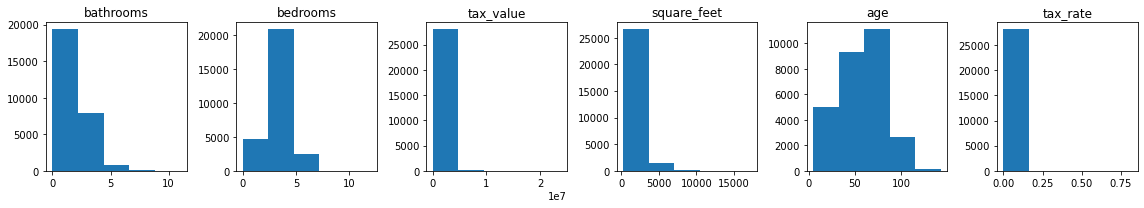

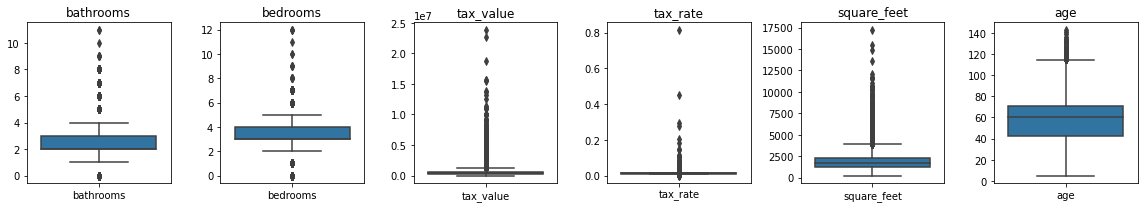

In [9]:
get_hist(df)
get_box(df)

##### Takeaways
- Remove outliers for a more balanced view of the dataset for modeling.

In [10]:
df = remove_outliers(df, k = 1.5, col_list = ['bathrooms', 'bedrooms', 'tax_value', 'tax_rate', 'square_feet', 'age'])

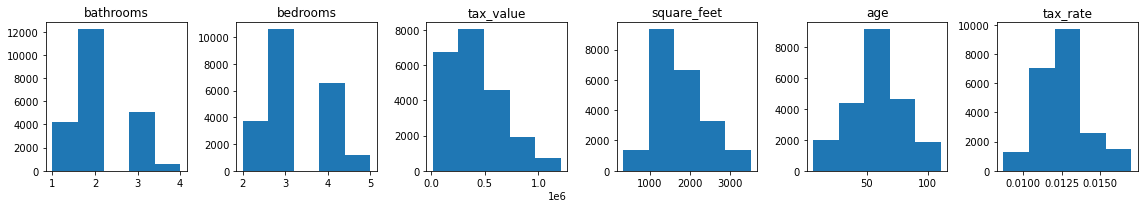

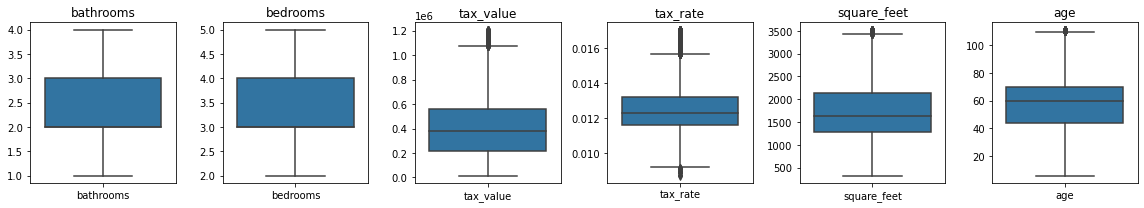

In [11]:
get_hist(df)
get_box(df)

##### Takeaways

1. Both tax_value and square_feet are right skewed
2. Normal distributions amongst the other features
3. Average home is between 2 and 3 bathrooms
4. 3 - 4 bedrooms
5. Average tax value is roughly 400K
6. Average tax rate just above 1.2 percent
7. Average square feet is just above 1500sqft
8. The average age of homes in this dataset is 60

## Data Exploration

### Split the dataset

In [12]:
train, validate, test = train_validate_test_split(df)

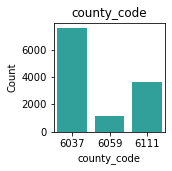

      county_code  Count  Percent
6037         6037   7548    61.13
6059         6111   3611    29.24
6111         6059   1189     9.63


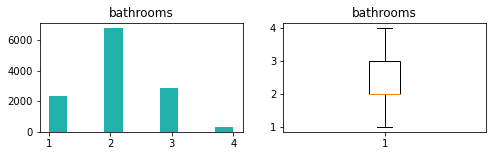

count    12348.000000
mean         2.099206
std          0.722739
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: bathrooms, dtype: float64


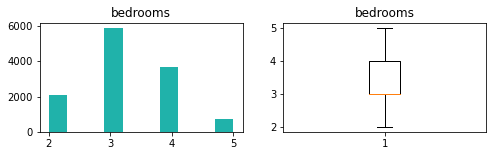

count    12348.000000
mean         3.244250
std          0.798544
min          2.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: bedrooms, dtype: float64


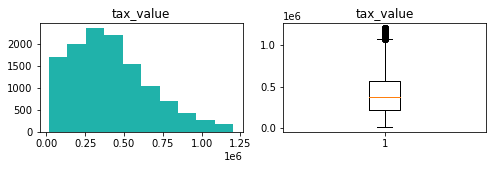

count    1.234800e+04
mean     4.163668e+05
std      2.525879e+05
min      1.608400e+04
25%      2.229975e+05
50%      3.811420e+05
75%      5.644125e+05
max      1.204898e+06
Name: tax_value, dtype: float64


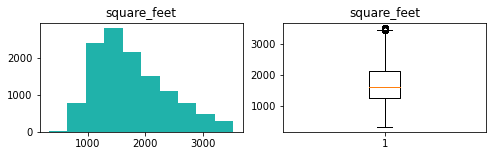

count    12348.000000
mean      1753.299563
std        623.510051
min        326.000000
25%       1273.000000
50%       1628.500000
75%       2142.000000
max       3524.000000
Name: square_feet, dtype: float64


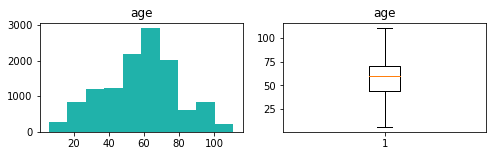

count    12348.000000
mean        58.181406
std         21.069838
min          6.000000
25%         44.000000
50%         60.000000
75%         71.000000
max        111.000000
Name: age, dtype: float64


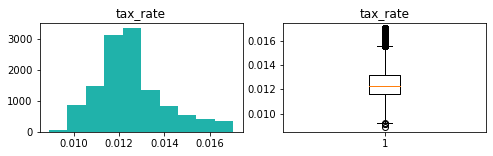

count    12348.000000
mean         0.012511
std          0.001496
min          0.008908
25%          0.011587
50%          0.012262
75%          0.013175
max          0.017044
Name: tax_rate, dtype: float64


In [13]:
explore_univariate(train, cat_vars = ['county_code'], quant_vars = ['bathrooms', 'bedrooms', 'tax_value',        
                                                                    'square_feet', 'age', 'tax_rate'])

##### Takeaways
1. In univariate exploration I got a glimse into several possible drivers that led me to the aforementioned hypothesis:
    - Homes in Los Angeles county make up 61% of the homes querried
    - Homes in Ventura county make up 29.24% of the homes querried
    - Homes in Orange county make up 9.63% of the homes querried
    - Average bathroom count is 2
    - Average bedroom count is 3
    - Average tax value is 416,366 dollars
    - Average square footage is 1,753 sqft
    - Average home age is 58 years
    - Average tax rate is 1.25%b

## Initial Hypothesis

##### Initial thoughts to explore using both bivariate and multivariate exploration
- Do homes in 6059 have haigher tax values then the rest of the population?
- Do Homes with four baths have a higher tax value then the rest of the populations?
- Do home with five bedrooms have a higher tax value then the rest of the population?
- Do 5 bedroom/4 bath homes in 6059 have higher tax value then the rest of the population?

## Bivariate Exploration
- Taking the trained data I wanted to look at tax value by county code, bathrooms, and bedrooms.

county_code vs tax_value


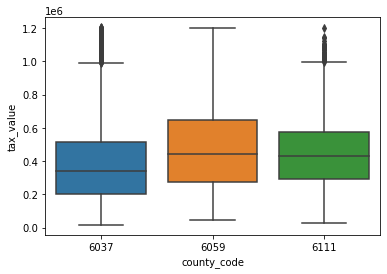

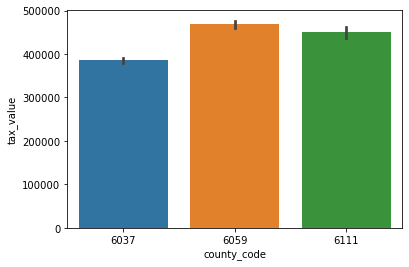

-------------------------------
Mean tax_value by county_code:  
county_code
6037    386158.489931
6059    468487.031847
6111    449845.395290
Name: tax_value, dtype: float64

bathrooms vs tax_value


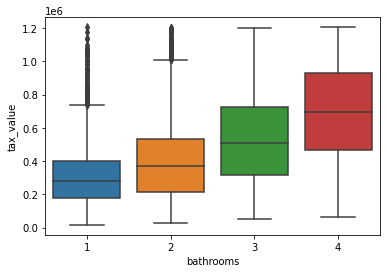

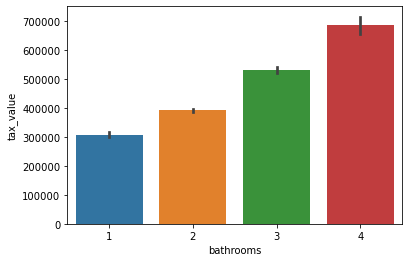

-------------------------------
Mean tax_value by bathrooms:  
bathrooms
1    307513.756838
2    391878.319510
3    530501.316316
4    685958.345345
Name: tax_value, dtype: float64

bedrooms vs tax_value


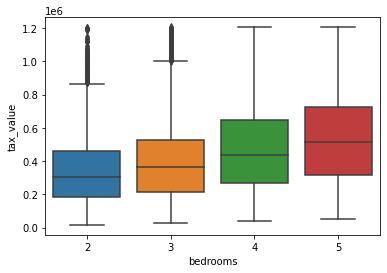

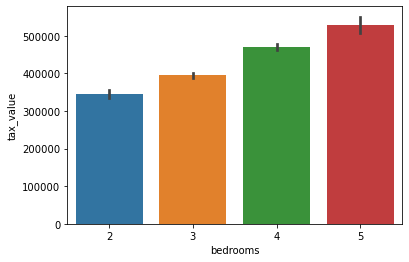

-------------------------------
Mean tax_value by bedrooms:  
bedrooms
2    345094.749880
3    394369.703306
4    470058.414879
5    529151.866197
Name: tax_value, dtype: float64



In [14]:
exp_bivariate_categorical('tax_value', ['county_code', 'bathrooms', 'bedrooms'], train)

##### Bivariate exploration takeaways
- Homes in Orange county (6059) have the highest tax value average at 468,487 dollars
- Followed by homes in Ventura county (6111) at 449,845 dollars and Los Angeles county (6037) at 386,158 dollars
- Homes with 4 bathrooms have a higher tax value average of 685,958 dollars
- Homes with 5 bedrooms have a higher tax value average of 529,151 dollars

## Multivariate Exploration
- Here I wanted to see the correlation between tax value, age, and square footage.
- I took a sample of 1500 of the train dataset. 

age vs tax_value


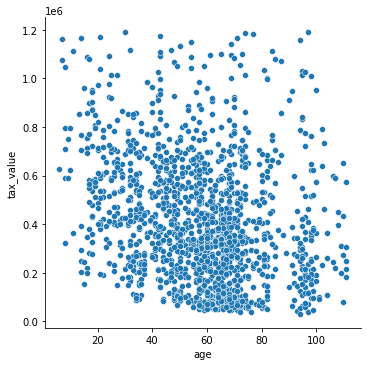

-------------------------------
Correlation between age and tax_value:  -0.25537679406040315
P value:  9.22914751872115e-24

square_feet vs tax_value


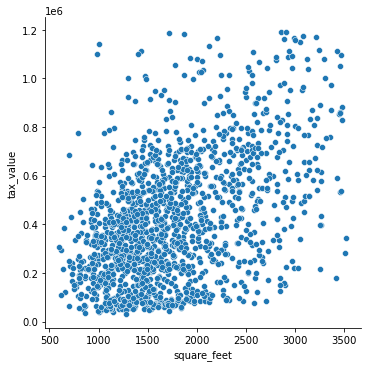

In [15]:
exp_bivariate_continuous('tax_value', ['age', 'square_feet'], train.sample(1500))

##### Multivariate exploration takeaways
- Age of the home does not really play into the tax value of the home
- The majority of homes are between 40 and 75 years old
- Seems to be a linear corrrelation between tax value and square footage

## Hypothesis and Testing
- I used a .05 alpha to test hypothesis.

##### 1. Do homes in 6059 have a higer tax values? (chi2)
- Null: Tax value is independent of homes in 6059.
- Alternate: Tax value is dependent of homes in 6059.

In [16]:
Null = 'Tax value is independent of homes in 6059.'
Alternate = 'Tax value is dependent of homes in 6059.'

observed = pd.crosstab(train.tax_value, train.county_code == 6059)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

-------------------------------
Correlation between square_feet and tax_value:  0.469349153987932
P value:  5.012612126263886e-83

chi^2 = 11219.2770
p     = 0.0000


We reject the null and accept the alternate: Tax value is dependent of homes in 6059.


##### 2. Do homes with three or more baths have a higher tax value? (chi2)
- Null: Tax value is independentt of three or more baths.
- Alternate: Tax value is dependent on three or more baths.

In [17]:
Null = 'Tax value is independentt of three or more bathrooms.'
Alternate = 'Tax value is dependent on three or more bathrooms.'

observed = pd.crosstab(train.tax_value, train.bathrooms >= 3)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 11051.7334
p     = 0.0010


We reject the null and accept the alternate: Tax value is dependent on three or more bathrooms.


##### 3. Do home with four or more bedrooms have a higher tax value? (chi2)
- Null: Tax value is independentt of four or more bedrooms.
- Alternate: Tax value is dependent on four or more bedrooms.

In [18]:
Null = 'Tax value is independent of four or more bedrooms.'
Alternate = 'Tax value is dependent on four or more bedrooms.'

observed = pd.crosstab(train.tax_value, train.bedrooms >= 4)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 10857.0250
p     = 0.0373


We reject the null and accept the alternate: Tax value is dependent on four or more bedrooms.


##### 4. Linear correlation between tax value and square footage of the home. (pearsonr)
- Null: Tax value and square footage are NOT lineraly correlated.
- Alternate: Tax value and square footage are lineraly correlated.

In [19]:
Null = 'Tax value and square footage are NOT lineraly correlated.'
Alternate = 'Tax value and square footage are lineraly correlated.'

corr, p = stats.pearsonr(train.tax_value, train.square_feet)

print(f'chi^2 = {corr:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 0.4500
p     = 0.0000


We reject the null and accept the alternate: Tax value and square footage are lineraly correlated.


# Modeling

##### Split dataset into samples
- Target: 'tax_value'
- Features: 'bedrooms', 'bathrooms', 'square_feet', 'county_code'

In [20]:
X_train = train[['bedrooms', 'bathrooms', 'square_feet', 'county_code']]#features
y_train = train.tax_value
X_validate = validate[['bedrooms', 'bathrooms', 'square_feet', 'county_code']]#features
y_validate = validate.tax_value
X_test = test[['bedrooms', 'bathrooms', 'square_feet', 'county_code']]#features
y_test = test.tax_value

### Scale
- I used the standard scaler for a better fit of the dataset.

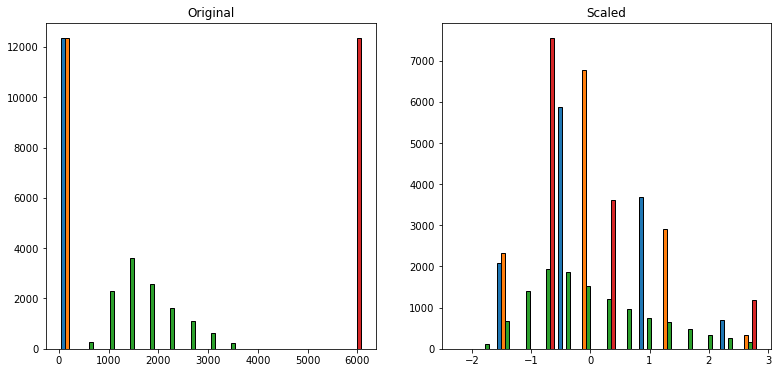

In [21]:
scale_it(X_train, X_validate, X_test)

### Feature Engineering
- I ran the samples through rfe and select_kbest with k and features set to one and three

##### rfe

In [22]:
rfe(X_train, y_train,k = 1)

Index(['square_feet'], dtype='object')

In [23]:
rfe(X_train, y_train,k = 3)

Index(['bedrooms', 'bathrooms', 'square_feet'], dtype='object')

##### kbest

In [24]:
select_kbest(X_train,y_train,k = 1)

Index(['square_feet'], dtype='object')

In [25]:
select_kbest(X_train,y_train,k = 3)

Index(['bedrooms', 'bathrooms', 'square_feet'], dtype='object')

##### Takeaways
- Both the rfe and kbest both return 'square_feet' as the most significant feature, followed by number bedrooms and bathrooms.

### Regression Modeling

#### Set the baseline
- Baseline function calculates baseline and adds columns to the dataframe

In [26]:
get_baseline(train,train[['square_feet']], train['tax_value'])

,bathrooms,bedrooms,county_code,tax_value,square_feet,age,tax_rate,yhat_baseline,yhat
3617,1,2,6037,103274,873,66,0.012373,416366.790492,255888.499545
19211,2,2,6037,863392,1126,74,0.012140,416366.790492,302010.307769
27983,2,3,6111,542000,1613,32,0.010956,416366.790492,390790.231109
20172,2,3,6037,257486,1466,69,0.012915,416366.790492,363992.184434
22141,1,3,6037,74798,1066,96,0.012125,416366.790492,291072.329534
...,...,...,...,...,...,...,...,...,...
27567,2,3,6037,212775,1392,80,0.011133,416366.790492,350502.011277
21173,3,4,6111,602135,3048,32,0.012748,416366.790492,652390.210562
5964,3,4,6037,274033,1996,65,0.013532,416366.790492,460610.992176
27850,2,3,6059,559527,1176,58,0.011369,416366.790492,311125.289631


##### Evaluate the residuals

In [27]:
get_residuals(train, train['tax_value'])

,bathrooms,bedrooms,county_code,tax_value,square_feet,age,tax_rate,yhat_baseline,yhat,residual,residual_baseline
3617,1,2,6037,103274,873,66,0.012373,416366.790492,255888.499545,152614.499545,313092.790492
19211,2,2,6037,863392,1126,74,0.012140,416366.790492,302010.307769,-561381.692231,-447025.209508
27983,2,3,6111,542000,1613,32,0.010956,416366.790492,390790.231109,-151209.768891,-125633.209508
20172,2,3,6037,257486,1466,69,0.012915,416366.790492,363992.184434,106506.184434,158880.790492
22141,1,3,6037,74798,1066,96,0.012125,416366.790492,291072.329534,216274.329534,341568.790492
...,...,...,...,...,...,...,...,...,...,...,...
27567,2,3,6037,212775,1392,80,0.011133,416366.790492,350502.011277,137727.011277,203591.790492
21173,3,4,6111,602135,3048,32,0.012748,416366.790492,652390.210562,50255.210562,-185768.209508
5964,3,4,6037,274033,1996,65,0.013532,416366.790492,460610.992176,186577.992176,142333.790492
27850,2,3,6059,559527,1176,58,0.011369,416366.790492,311125.289631,-248401.710369,-143160.209508


##### Plot residual

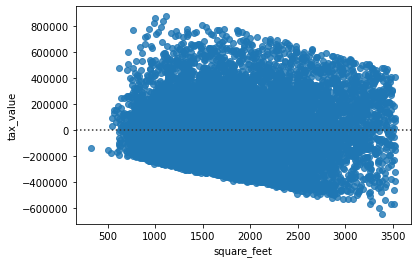

In [28]:
plot_residual(train, train[['square_feet']], train['tax_value'])

##### Errors

In [29]:
regression_errors(train, train['tax_value'], train.yhat)

(50876622990.17164,
 628224540682639.4,
 159521775363024.0,
 787746316045663.4,
 225558.4691164835)

In [30]:
baseline_mean_errors(train, train['tax_value'], train.yhat_baseline)

(63795458053.58463, 787746316045663.0, 252577.62777725313)

### Is the model better then the baseline

In [31]:
better_than_baseline(regression_errors = True, baseline_mean_errors = True)

The model is better then the baseline.


# Modeling

##### Baseline model

In [32]:
model_baseline(y_train, y_validate, 'tax_value')

RMSE using Mean
Train/In-Sample:  252577.63 
Validate/Out-of-Sample:  251230.56
RMSE using Median
Train/In-Sample:  255022.05 
Validate/Out-of-Sample:  252468.19


#### LinearRegression (OLS)

In [33]:
linear_regression(y_train, X_train, y_validate, X_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  224125.06629133702 
Validation/Out-of-Sample:  222786.8279825475


#### LassoLars

In [34]:
lassolars(y_train, X_train, y_validate, X_validate)

RMSE for Lasso + Lars
Training/In-Sample:  224125.2585597165 
Validation/Out-of-Sample:  222785.17195160186


#### TweedieRegressor (GLM)

In [35]:
tweedieregressor(y_train, X_train, y_validate, X_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  252577.62777725313 
Validation/Out-of-Sample:  251230.5592725626


#### Polynomial Regression

In [36]:
polynomialregression(y_train, X_train, y_validate, X_validate, X_test)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  222773.07956697376 
Validation/Out-of-Sample:  221208.99610532908


## Model test sample

In [37]:
model_test(X_test, y_test)

RMSE for Polynomial Model, degrees=2
Test:  221666.78061644992


# Tax_Rate by County

county_code vs tax_rate


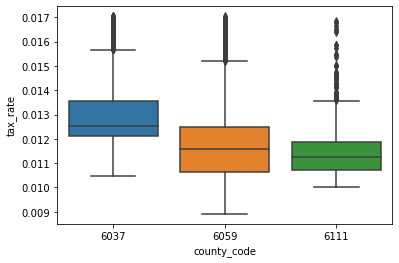

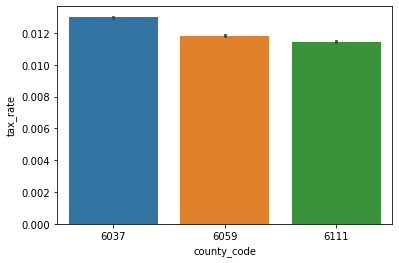

-------------------------------
Mean tax_rate by county_code:  
county_code
6037    0.012993
6059    0.011846
6111    0.011470
Name: tax_rate, dtype: float64



In [38]:
exp_bivariate_categorical('tax_rate', ['county_code'], train)

In [39]:
#split county codes for tax rate plot distributions before running the function.
county_6037 = df[df.county_code == 6037]
county_6059 = df[df.county_code == 6059]
county_6111 = df[df.county_code == 6111]

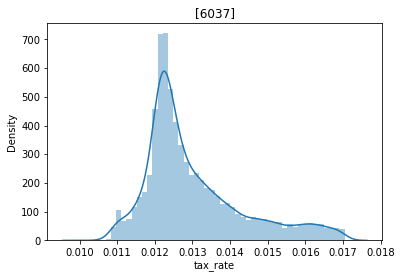


count    13479.000000
mean         0.013014
std          0.001326
min          0.010141
25%          0.012147
50%          0.012558
75%          0.013584
max          0.017044
Name: tax_rate, dtype: float64


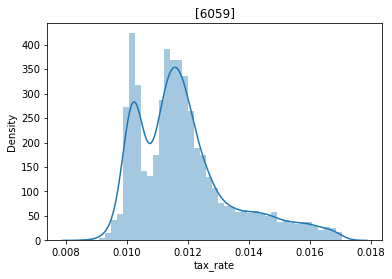


count    6447.000000
mean        0.011862
std         0.001586
min         0.008702
25%         0.010666
50%         0.011580
75%         0.012476
max         0.017039
Name: tax_rate, dtype: float64


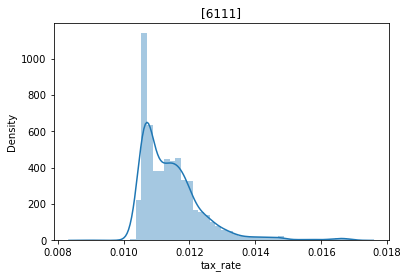


count    2124.000000
mean        0.011470
std         0.000980
min         0.008977
25%         0.010726
50%         0.011272
75%         0.011853
max         0.016943
Name: tax_rate, dtype: float64


In [40]:
#counties, x_value, group_key
plot_distributions([county_6037, county_6059, county_6111], 'tax_rate', 'county_code')